In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

d:\anaconda\envs\env_v3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../../data/preprocessed/realestates_kh_SelectKBest_v2.csv')

In [3]:
# # Advanced feature engineering

# def add_features(df):
#     # Phnom Penh center coordinates
#     PP_CENTER = (11.5761468, 104.9205142)
    
#     # Spatial features
#     df['dist_to_center'] = np.sqrt(
#         (df['latitude'] - PP_CENTER[0])**2 + 
#         (df['longitude'] - PP_CENTER[1])**2
#     )
    
#     # Interaction features
#     df['size_per_room'] = df['property_size_sqm'] / df['bedrooms'].clip(1)
#     df['price_per_room'] = df['price_per_m2'] * df['property_size_sqm'] / df['bedrooms'].clip(1)
    
#     # Temporal features
#     current_year = pd.Timestamp.now().year
#     df['building_age'] = current_year - df['year_built'].clip(1900, current_year)
#     df['renovation_age'] = np.where(
#         df['year_renovated'] > 0, 
#         current_year - df['year_renovated'], 
#         df['building_age']
#     )
    
#     # Polynomial features
#     df['size_squared'] = df['property_size_sqm'] ** 2
#     df['dist_squared'] = df['dist_to_center'] ** 2
    
#     return df

# df = add_features(df)

In [4]:
# Prepare data
X = df.drop(['price_per_m2'], axis=1)
y = df['price_per_m2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
# Advanced target transformation
target_transformer = PowerTransformer(method='yeo-johnson')
y_train_trans = target_transformer.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_trans = target_transformer.transform(y_test.values.reshape(-1, 1)).flatten()

# For inverse transform
def inverse_transform(y_trans):
    return target_transformer.inverse_transform(y_trans.reshape(-1, 1)).flatten()


In [6]:
# Initialize models with new additions
models = {
    "LightGBM": lgb.LGBMRegressor(random_state=42, verbose=-1),
    "XGBoost": xgb.XGBRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0),
    "MLP": MLPRegressor(random_state=42, max_iter=1000),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

In [7]:
# Enhanced parameter grids
param_grids = {
    "LightGBM": {
        'num_leaves': [15, 31, 63],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [500, 1000, 1500],
        'min_child_samples': [5, 20, 50],
        'reg_alpha': [0, 0.1, 1, 10],
        'reg_lambda': [0, 0.1, 1, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    "XGBoost": {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [500, 1000, 1500],
        'gamma': [0, 0.1, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0, 0.1, 1]
    },
    "Random Forest": {
        'n_estimators': [300, 500, 800],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 0.8, None],
        'bootstrap': [True, False]
    },
    "CatBoost": {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [500, 1000, 1500],
        'l2_leaf_reg': [1, 3, 5],
        'random_strength': [0, 0.1, 1]
    },
    "MLP": {
        'hidden_layer_sizes': [(50,), (100, 50), (200, 100)],
        'alpha': [0.0001, 0.001, 0.01],
        'batch_size': [32, 64],
        'learning_rate_init': [0.001, 0.01],
        'early_stopping': [True]
    },
    "GradientBoosting": {
        'n_estimators': [500, 1000],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 0.8]
    }
}

In [8]:
# Tuning setup
tuning_method = {name: RandomizedSearchCV for name in models}
search_params = {
    'cv': 5,
    'scoring': 'r2',
    'n_jobs': -1,
    'verbose': 1
}

randomized_settings = {'n_iter': 30}


In [9]:
# Tune models with transformed target
tuned_models = {}
best_params = {}

for name, model in models.items():
    print(f"\n{'='*40}\nTuning {name}\n{'='*40}")
    
    search = RandomizedSearchCV(
        model,
        param_grids[name],
        **search_params,
        **randomized_settings,
        random_state=42
    )
    
    search.fit(X_train, y_train_trans)
    
    tuned_models[name] = search.best_estimator_
    best_params[name] = search.best_params_
    
    print(f"Best R²: {search.best_score_:.4f}")
    print(f"Best params: {search.best_params_}")


Tuning LightGBM
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best R²: 0.9854
Best params: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0, 'num_leaves': 31, 'n_estimators': 1000, 'min_child_samples': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

Tuning XGBoost
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best R²: 0.9839
Best params: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}

Tuning Random Forest
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best R²: 0.9761
Best params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'bootstrap': True}

Tuning CatBoost
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best R²: 0.9884
Best params: {'random_strength': 1, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 1500, 'depth': 6}

Tuning MLP
Fitting 5 folds

In [10]:
# Select best model for feature selection
best_model_name = max(
    tuned_models, 
    key=lambda x: cross_val_score(
        tuned_models[x], X_train, y_train_trans, cv=5, scoring='r2'
    ).mean()
)
best_model = tuned_models[best_model_name]

In [11]:
# # Feature selection with RFECV
# print("\nPerforming feature selection...")
# selector = RFECV(
#     estimator=best_model,
#     step=1,
#     cv=5,
#     scoring='r2',
#     min_features_to_select=15,
#     n_jobs=-1
# )

# selector.fit(X_train, y_train_trans)
# selected_features = X_train.columns[selector.support_]
# print(f"Selected {len(selected_features)} features:")
# print(selected_features.tolist())

In [12]:
# X_train_sel = X_train[selected_features]
# X_test_sel = X_test[selected_features]

In [13]:
# Hyperparameter optimization with Optuna
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 7, 63),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    
    model = lgb.LGBMRegressor(**params, random_state=42)
    score = cross_val_score(
        model, 
        X_train, 
        y_train_trans, 
        cv=5, 
        scoring='r2', 
        n_jobs=-1
    ).mean()
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-06-23 14:30:11,646] A new study created in memory with name: no-name-94083289-319d-478e-80fe-8cac434d7d48
[I 2025-06-23 14:30:34,933] Trial 0 finished with value: 0.9637354304200636 and parameters: {'num_leaves': 41, 'learning_rate': 0.023753817226656204, 'n_estimators': 1839, 'min_child_samples': 9, 'reg_alpha': 6.7189467247119216e-09, 'reg_lambda': 0.016526951395874123, 'subsample': 0.6214212887974703, 'colsample_bytree': 0.5529693854211548}. Best is trial 0 with value: 0.9637354304200636.
[I 2025-06-23 14:30:53,351] Trial 1 finished with value: 0.971667458518994 and parameters: {'num_leaves': 44, 'learning_rate': 0.028610364762328883, 'n_estimators': 1729, 'min_child_samples': 46, 'reg_alpha': 0.24723255223351287, 'reg_lambda': 1.626265220774899e-06, 'subsample': 0.993578427996705, 'colsample_bytree': 0.7384880462566059}. Best is trial 1 with value: 0.971667458518994.
[I 2025-06-23 14:31:13,474] Trial 2 finished with value: 0.9701984896997855 and parameters: {'num_leaves': 4

In [14]:

# Create optimized model
optimized_params = study.best_params
optimized_model = lgb.LGBMRegressor(**optimized_params, random_state=42)
optimized_model.fit(X_train, y_train_trans)

LGBMRegressor(colsample_bytree=0.9650766031427457,
              learning_rate=0.013602354201864127, min_child_samples=5,
              n_estimators=1551, num_leaves=29, random_state=42,
              reg_alpha=0.008443189879430199, reg_lambda=0.001965313871321741,
              subsample=0.7781080004278483)

In [15]:
# Build stacking ensemble
base_models = [
    ('optimized_lgb', optimized_model),
    ('xgb', tuned_models['XGBoost']),
    ('cat', tuned_models['CatBoost'])
]

In [16]:
from sklearn.linear_model import RidgeCV
# Meta-model with hyperparameter tuning
meta_model = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100])

stack_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

In [17]:
# Train and evaluate stacking
stack_model.fit(X_train, y_train_trans)
stack_score = cross_val_score(
    stack_model, X_train, y_train_trans, cv=5, scoring='r2'
).mean()
print(f"\nStacking Model CV R²: {stack_score:.4f}")



Stacking Model CV R²: 0.5708


In [18]:
# Final evaluation
def evaluate_model(model, X, y_true_trans):
    y_pred_trans = model.predict(X)
    y_pred = inverse_transform(y_pred_trans)
    y_true = inverse_transform(y_true_trans)
    
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Avg Price: {y_true.mean():.2f}")
    
    return y_pred

print("\nOptimized Model Performance:")
y_pred_optimized = evaluate_model(optimized_model, X_test, y_test_trans)

print("\nStacking Model Performance:")
y_pred_stack = evaluate_model(stack_model, X_test, y_test_trans)


Optimized Model Performance:
R²: 0.9757
MAE: 73.05
MAPE: 4.27%
Avg Price: 2048.73

Stacking Model Performance:
R²: 0.9223
MAE: 157.19
MAPE: 8.73%
Avg Price: 2048.73


In [19]:
# Model interpretation with SHAP
explainer = shap.Explainer(optimized_model)
shap_values = explainer(X_train)



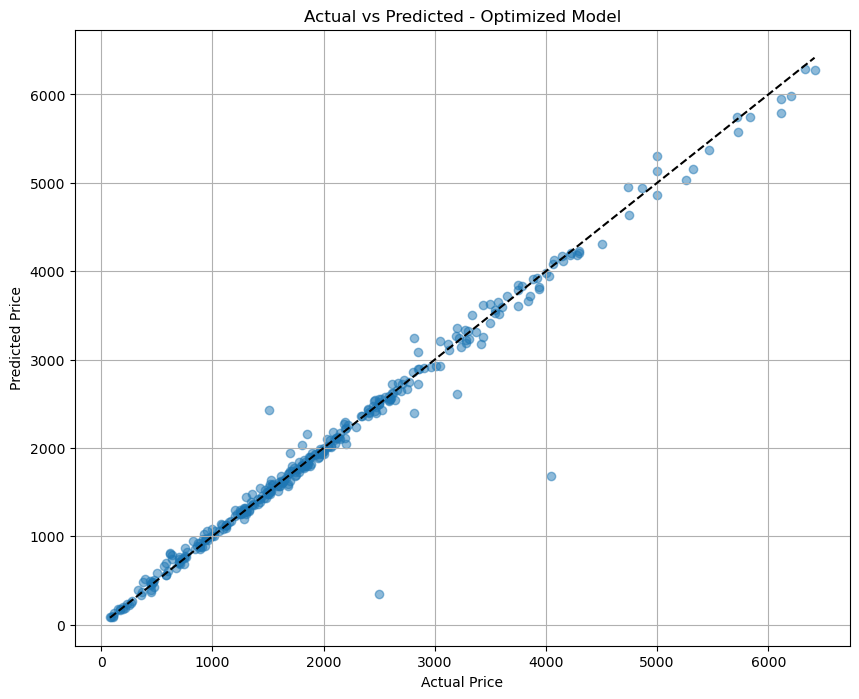

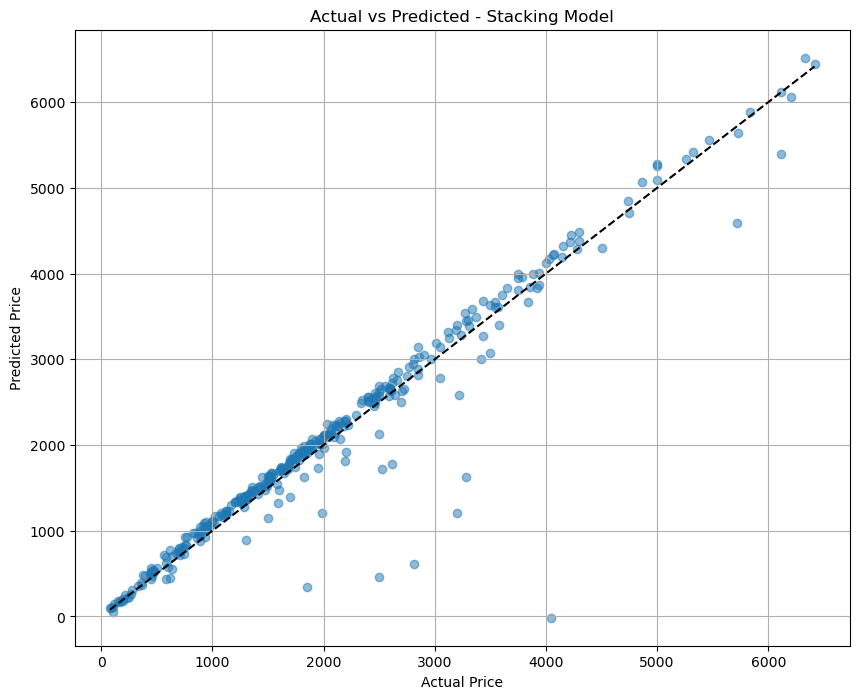

In [20]:
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], 
             [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.grid(True)
    plt.show()

y_test_actual = inverse_transform(y_test_trans)
plot_actual_vs_predicted(y_test_actual, y_pred_optimized, "Optimized Model")
plot_actual_vs_predicted(y_test_actual, y_pred_stack, "Stacking Model")
